# 第十一週：Text Presentation
本周課程為「Text Presentation」，主要會使用到gensim套件來實現自行訓練word2vec模型以及使用預訓練word2vec模型，以及透過sentence-transformers以及API取得embeddings。


### 大綱：
1.   DEMO
*   Word2Vec
  *   自己訓練w2v模型
  *   使用別人訓練好的w2v模型
*   Transformers Embeddings
  *   小模型（BERT）：
      *   不同語言的BERT：uncased / chinese / multilingual
  *   大模型（LLM）：
      *   API based
      *   Open Source LLM  

2.   資料集實作任務
*    使用embedding 做 NLP 任務
  *   找相似文件（文章）
  *   文件分類任務


### 套件安裝

連接雲端資料夾

In [1]:
import os

# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('你的雲端資料夾路徑') #切換該目錄
# os.listdir() #確認目錄內容

In [3]:
# !pip install scikit-learn-extra
# !pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 48.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314459 sha256=7d61f0f97927ba72a7e9ee185c2738dd961fc7c2397b6ef21c85f36e16efa6b6
  Stored in directory: /root/.cache/pip/wheels/c9/69/31/d56d90b22a1777b0b231e234b00302a55be255930f8bd92dcd
Successfully built jieba


In [1]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")


### 資料前處理

讀入吃到飽示範資料集

In [2]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [3]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [4]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/00940.csv')

In [5]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

Building prefix dict from c:\Users\USER\Desktop\final_scribble\SMA\week11\dict\dict.txt.big ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.u25a6aa97dbbbbfeb7f76616913614093.cache


Loading model cost 0.872 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
1,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,元大加入月配息戰場,"[元大, 配息, 戰場]"
2,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,發行價元有收益平準金月號募集,"[發行價, 元有, 收益, 平準, 金月號, 募集]"
3,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文連結發布時間,"[連結, 發布, 時間]"
4,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,聯合新聞網綜合報導,"[聯合, 新聞網, 綜合]"
5,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,記者署名,[署名]
...,...,...,...,...,...,...,...
6473,227,https://www.ptt.cc/bbs/Stock/M.1710780874.A.EB...,[心得]殖利率有什麼好比的,2024-03-19 00:54:32,一般看到的 殖利率＝ 股息/除息前的股價\n\n而股價是隨時在變的，在以往ETF盛行之前，\...,是這個時間這個時代的台灣好賺,"[時間, 時代, 台灣, 好賺]"
6474,227,https://www.ptt.cc/bbs/Stock/M.1710780874.A.EB...,[心得]殖利率有什麼好比的,2024-03-19 00:54:32,一般看到的 殖利率＝ 股息/除息前的股價\n\n而股價是隨時在變的，在以往ETF盛行之前，\...,如果是陸股港股那種樣子,"[陸股, 港股, 那種, 樣子]"
6475,227,https://www.ptt.cc/bbs/Stock/M.1710780874.A.EB...,[心得]殖利率有什麼好比的,2024-03-19 00:54:32,一般看到的 殖利率＝ 股息/除息前的股價\n\n而股價是隨時在變的，在以往ETF盛行之前，\...,發行,[發行]
6476,227,https://www.ptt.cc/bbs/Stock/M.1710780874.A.EB...,[心得]殖利率有什麼好比的,2024-03-19 00:54:32,一般看到的 殖利率＝ 股息/除息前的股價\n\n而股價是隨時在變的，在以往ETF盛行之前，\...,應該也沒人想買,[沒人]


### word2vec


####（1）如何自己訓練word2vec模型

建立訓練資料時將考慮bigram，以下為Phrases函式的使用示範

In [7]:
docs = ['new york is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
# Phrases 建立bigram,
# 少於min_count的字的字或bigrams會被忽略,
# 大於threshold的bigrams會被加入
bigram = Phrases(token_, min_count=1, threshold=2)
bigram_phraser = Phraser(bigram)

for sent in token_:
    print(sent)  #處理前
    print("=> ",bigram_phraser[sent]) # 處理後，還是原本的句子，只是有抓出的bigram片語會被合併

['new', 'york', 'is', 'united', 'states']
=>  ['new_york', 'is', 'united', 'states']
['new', 'york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
=>  ['new_york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
['i', 'love', 'to', 'stay', 'in', 'new', 'york']
=>  ['i', 'love', 'to', 'stay', 'in', 'new_york']


實際應用在資料集上

In [6]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word,word_list_bigrams
1,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,元大加入月配息戰場,"[元大, 配息, 戰場]","[元大, 配息, 戰場]"
2,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,發行價元有收益平準金月號募集,"[發行價, 元有, 收益, 平準, 金月號, 募集]","[發行價, 元有, 收益, 平準, 金月號, 募集]"
3,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文連結發布時間,"[連結, 發布, 時間]","[連結, 發布, 時間]"
4,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,聯合新聞網綜合報導,"[聯合, 新聞網, 綜合]","[聯合, 新聞網, 綜合]"
5,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,記者署名,[署名],[署名]


In [7]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [8]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 6492


['股息', '申購', '高息', '投資', '台灣', '募集', '市場', '長榮', '億元', '投信']

In [9]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 5943
average length of sentences: 3.8056537102473498


Word2Vec 計算

In [10]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [11]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 16


In [12]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

查看結果

In [13]:
# 檢查最相關的字
w2v_model.wv.most_similar('股息',topn=10)

[('高息', 0.9478349089622498),
 ('募集', 0.9433968663215637),
 ('台灣', 0.939914882183075),
 ('臺灣', 0.9277253746986389),
 ('市場', 0.919761061668396),
 ('億元', 0.915317177772522),
 ('元大', 0.9135890603065491),
 ('規模', 0.9132897853851318),
 ('金額', 0.913271963596344),
 ('基金', 0.9128413796424866)]

In [14]:
w2v_model.wv.most_similar('申購',topn=10)

[('億元', 0.9406101703643799),
 ('募集', 0.9372378587722778),
 ('金額', 0.9267922639846802),
 ('投信', 0.9203624725341797),
 ('超過', 0.9196386337280273),
 ('高息', 0.9191388487815857),
 ('元大', 0.9143776297569275),
 ('規模', 0.9102748036384583),
 ('公司', 0.9101777076721191),
 ('臺灣', 0.9089953899383545)]

In [15]:
w2v_model.wv.most_similar(['股息','申購'],topn=10)

[('募集', 0.9627600312232971),
 ('高息', 0.9557664394378662),
 ('億元', 0.9501112699508667),
 ('台灣', 0.9432446360588074),
 ('金額', 0.941990315914154),
 ('臺灣', 0.9402788281440735),
 ('投信', 0.9378176331520081),
 ('元大', 0.9357972145080566),
 ('規模', 0.9335436820983887),
 ('超過', 0.9309914112091064)]

In [16]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['股息','申購'],topn=10)

[('億美元', 0.38373687863349915),
 ('評論', 0.3268243968486786),
 ('增加', -0.30295929312705994),
 ('產品', -0.4202312231063843),
 ('去年', -0.4313148558139801),
 ('累計', -0.4476418197154999),
 ('價格', -0.49910956621170044),
 ('半導體', -0.5184584856033325),
 ('上漲', -0.5266651511192322),
 ('千億', -0.5771532654762268)]

In [20]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("元大","公司")

0.9275038

In [19]:
w2v_model.wv.similarity("基金","金額")

0.88184273

In [21]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["元大", "公司", '金額'])

'金額'

In [22]:
# 相對關係
w2v_model.wv.most_similar(positive=["元大"], negative=["公司"], topn=5)

[('價格', 0.17731767892837524),
 ('持股', 0.16952192783355713),
 ('投資人', 0.16172152757644653),
 ('心得', 0.15019415318965912),
 ('儲蓄', 0.14549458026885986)]

In [23]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [24]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [25]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [26]:
getVecs(w2v_model,['申購','股票'])

array([[ 5.40848449e-03, -3.58139654e-03, -3.08570154e-02,
         3.50480787e-02,  3.09865940e-02, -7.48371193e-03,
         9.62602161e-03,  1.52905937e-03, -8.43580533e-03,
         1.43754976e-02,  1.05322395e-02, -5.63004799e-03,
        -1.07428897e-02, -1.25283897e-02, -2.31639226e-03,
         6.27686270e-03,  2.74863672e-02, -6.98445132e-03,
         3.99121735e-03,  1.76052703e-03,  7.28703709e-03,
         1.44842137e-02,  2.42119022e-02,  2.14462951e-02,
        -1.41177364e-02,  1.99207682e-02, -4.28919774e-03,
         1.50549402e-02, -1.02329138e-03, -2.44790339e-04,
         2.55355868e-03,  2.34187655e-02,  7.95444660e-03,
         1.20250438e-03, -8.72264523e-03, -3.72565016e-02,
        -4.05671448e-03, -9.40571539e-03, -9.31464788e-03,
        -3.39767034e-03, -3.46354744e-03,  9.44533199e-03,
        -4.75421402e-04,  3.05105373e-02, -6.00748882e-03,
        -8.27570353e-03, -2.35247542e-03,  2.76292227e-02,
         2.07851343e-02, -3.27197388e-02,  3.85338962e-0

In [27]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [28]:
expandPosWord(w2v_model,['申購','高息'],top_n = 10)

['公司',
 '臺灣',
 '元大台灣',
 '市場',
 '募集',
 '金額',
 '高息',
 '投資',
 '股息',
 '億元',
 '元大',
 '台灣',
 '投信',
 '規模',
 '指數',
 '超過']

In [29]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [31]:
sample_words = np.random.choice(list(words),300,replace=True).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [32]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

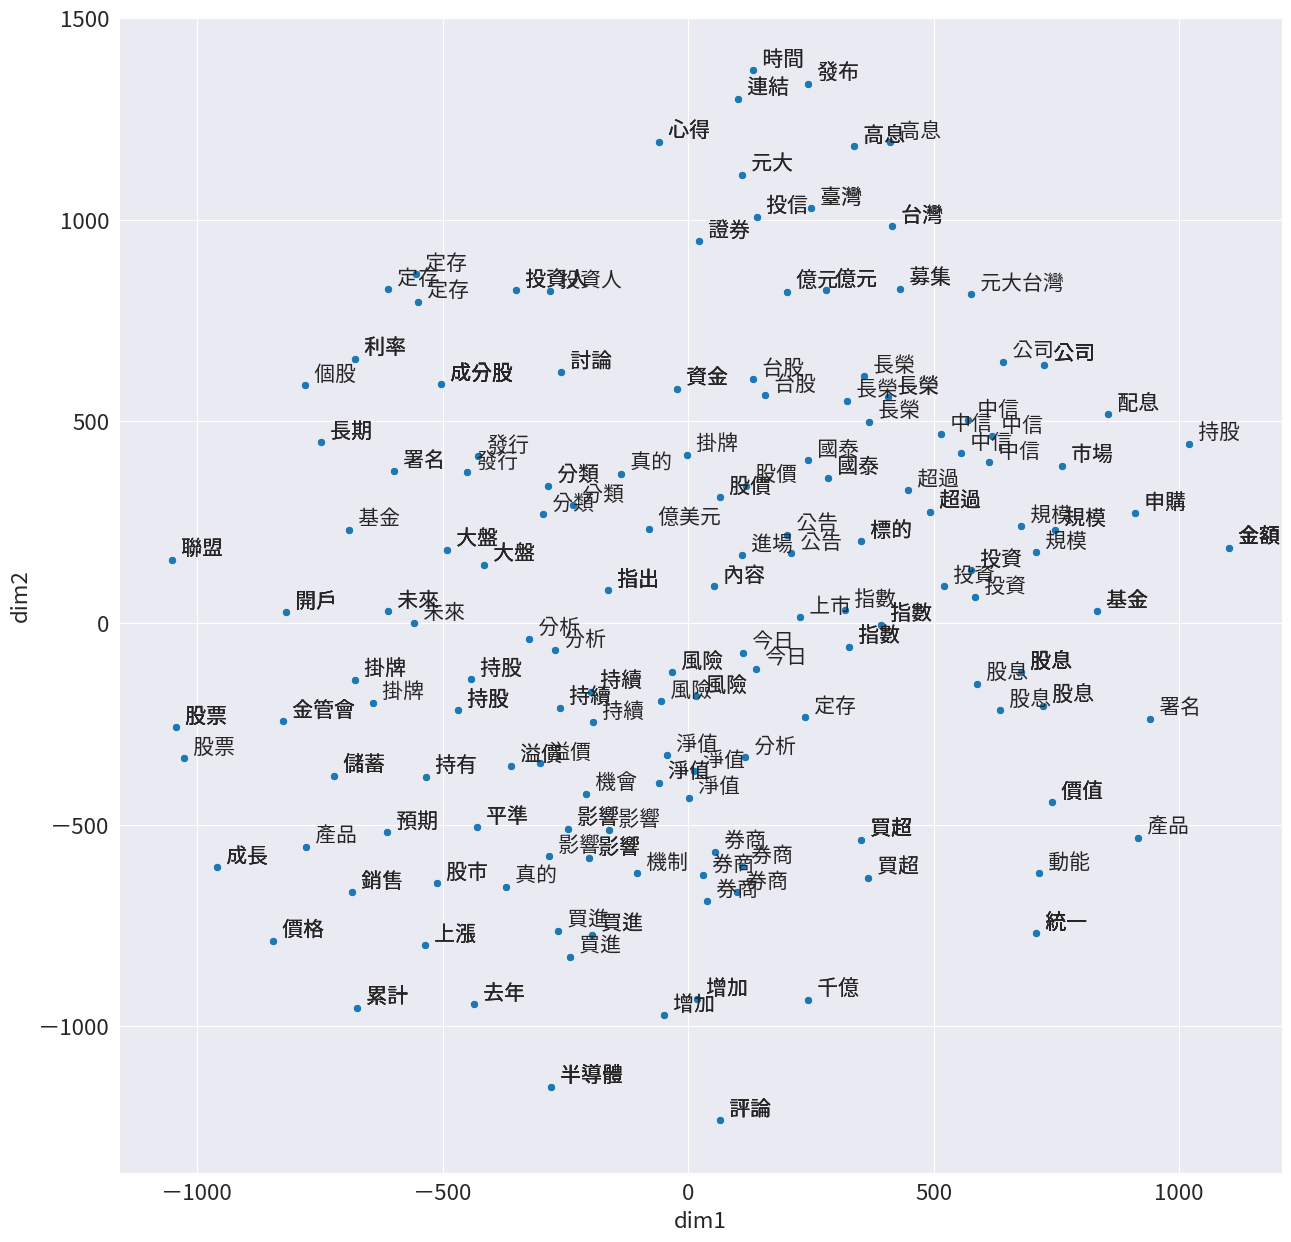

In [33]:
plotScatter(word_df)

3D 散狀圖

In [34]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


將字分群

In [80]:
!pip install scikit-learn-extra

In [36]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [37]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

c:\Users\USER\miniconda3\envs\SMA_new\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



####（2）如何使用別人訓練好的word2vec模型

臺北醫學大學做的預訓練 Word2Vec 模型，來源：http://nlp.tmu.edu.tw/word2vec/index.html

In [39]:
model_tmu = KeyedVectors.load_word2vec_format('./y_360W_cbow_2D_50dim_2020v1.bin', unicode_errors='ignore', binary=True)

In [40]:
model_tmu.most_similar('癌症',topn=10)

[('肝癌', 0.8965061902999878),
 ('乳癌', 0.894655168056488),
 ('肺癌', 0.8924040198326111),
 ('肝病', 0.8478196859359741),
 ('大腸癌', 0.8448510766029358),
 ('糖尿病', 0.8433824181556702),
 ('口腔癌', 0.8214656710624695),
 ('疾病', 0.8192287683486938),
 ('胃癌', 0.8169611096382141),
 ('腸癌', 0.8160045742988586)]

In [41]:
model_tmu.most_similar('咳嗽',topn=10)

[('流鼻水', 0.8725693225860596),
 ('鼻塞', 0.8663491010665894),
 ('嘔吐', 0.8655411601066589),
 ('腹瀉', 0.8551325798034668),
 ('感冒', 0.8539074063301086),
 ('乾咳', 0.8232213854789734),
 ('胸悶', 0.8225348591804504),
 ('胸痛', 0.8140345811843872),
 ('腹痛', 0.8083592057228088),
 ('頭暈', 0.8059035539627075)]

In [42]:
model_tmu.most_similar(positive=['疾病','咳嗽'],topn=10)

[('症狀', 0.8799884915351868),
 ('癥狀', 0.8648518919944763),
 ('哮喘', 0.8594630360603333),
 ('慢性', 0.8578190803527832),
 ('氣喘', 0.8548911809921265),
 ('感冒', 0.8509713411331177),
 ('腹瀉', 0.8316847085952759),
 ('病症', 0.8148555159568787),
 ('急性', 0.8118695020675659),
 ('癲癇', 0.802987277507782)]

### Transformers Embeddings

#### 使用 Sentence-Transformer 套件   
參考資料：https://www.sbert.net/index.html

In [8]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.7 MB/s eta 0:00:00


In [39]:
from sentence_transformers import SentenceTransformer, models, util

c:\Users\USER\miniconda3\envs\SMA_new\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



#### 小模型，以BERT為範例

註：在挑選語言模型時需確認其訓練資料的來源，因為不一定都具備跨語言的能力。   
接下來將以針對英文、中文以及多語言進行訓練的三種BERT模型做範例。

In [40]:
# 英文 bert-base-uncased
bert_en = SentenceTransformer('google-bert/bert-base-uncased')

bert_en.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-uncased. Creating a new one with MEAN pooling.


0

In [41]:
bert_en.get_max_seq_length()

512

In [42]:
example_text = "This framework generates embeddings for each input sentence"
example_embeddings = bert_en.encode(example_text)

print(example_embeddings.shape)
print("=======================")
print(example_embeddings)

(768,)
[-1.25634268e-01 -2.35389192e-02  9.72146913e-02 -2.14601755e-01
 -4.24762331e-02 -7.68912770e-03  1.66509092e-01  2.09751531e-01
  1.94057137e-01 -9.31545421e-02 -1.04051106e-01 -1.99633539e-01
 -3.48384261e-01  8.10465291e-02 -1.62065346e-02  1.90525934e-01
  5.29440993e-04  1.45439580e-01 -5.54228085e-04 -1.58491150e-01
  1.94275752e-01  1.59165591e-01 -5.99901080e-01  2.65521944e-01
  7.47946382e-01 -2.46564695e-03  1.04437068e-01  1.66958481e-01
 -3.53779137e-01  1.39418662e-01  3.89939807e-02  6.57110274e-01
 -6.23255270e-03 -2.85024047e-01 -1.56141192e-01  8.45849887e-02
  1.65655285e-01 -2.55370319e-01 -1.16442613e-01  9.59286690e-02
 -6.72327101e-01 -3.47995132e-01  8.42585042e-02 -2.06027716e-01
 -5.32230586e-02 -4.90706474e-01 -9.41132568e-03 -3.81040990e-01
  5.67959584e-02 -6.35587990e-01 -1.04700708e+00  3.73333037e-01
  1.31077349e-01  3.08176398e-01 -2.27984086e-01  8.04123998e-01
  1.21666417e-01 -7.21640468e-01  3.69301647e-01 -1.17350630e-01
  1.25593275e-01 -

In [43]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_en = bert_en.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_en, embeddings_en)

# 印出句子間的cosine similarity分數
result = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
result_df.sort_values("score", ascending = False)

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.880907
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.499376
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.480858


因為後續在查看結果時會一直使用到此程式碼，所以包成function以便之後使用。

In [44]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

中文 bert-base-chinese

In [45]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with MEAN pooling.


0

In [46]:
# 示範句子
sentences = [
    "今天天氣很好。",
    "今天是個晴空萬里的好天氣。",
    "我晚上想去公園散步。"
]

# 使用 encode() 對資料做embedding
embeddings_ch = bert_ch.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_ch, embeddings_ch)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
0,今天天氣很好。,今天是個晴空萬里的好天氣。,0.914067
1,今天天氣很好。,我晚上想去公園散步。,0.787590
2,今天是個晴空萬里的好天氣。,我晚上想去公園散步。,0.759642


多語言 bert-base-multilingual-cased

In [47]:
# 多語言 bert-base-multilingual-cased
bert_multi = SentenceTransformer('google-bert/bert-base-multilingual-cased')

bert_multi.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-multilingual-cased. Creating a new one with MEAN pooling.


0

In [48]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。"
]

# 使用 encode() 對資料做embedding
embeddings_multi = bert_multi.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_multi, embeddings_multi)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.588525
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.362765
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.350699


#### 大模型範例

In [10]:
!pip install tiktoken
!pip install utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=31d3ffd33b08dda4af2f830144364ea6c51d58dabbc6ed05535592c0d1232019
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


#### (1)API based

##### OpenAI

**注意**   
Openai的API會要求綁定信用卡後才能使用，且綁定信用卡後會刷5美金的初始費用。   
請自行斟酌是否要嘗試這一部分的程式碼！


In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


In [13]:
# from openai import OpenAI
import openai
import os

openai.api_key = '你的API_KEY' # 設置API_KEY

def get_embedding_openai(text, model):
   #text = text.replace("\n", " ")
   return openai.embeddings.create(input = [text], model=model).data[0].embedding

In [14]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [17]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。",
    "速い茶色のキツネが怠惰な犬を飛び越える"
]

# 取得每一句的embedding
embeddings_openai = [get_embedding_openai(text, model=embedding_model) for text in sentences]

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_openai, embeddings_openai)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
3,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.598573
5,敏捷的棕色狐狸跳過了懶惰的狗。,速い茶色のキツネが怠惰な犬を飛び越える,0.572717
4,The quick brown fox jumps over the lazy dog.,速い茶色のキツネが怠惰な犬を飛び越える,0.493010
2,This framework generates embeddings for each i...,速い茶色のキツネが怠惰な犬を飛び越える,0.050702
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.030703
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.024827


##### Cohere

In [18]:
!pip install cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.1 MB/s eta 0:00:00


In [19]:
import cohere

co = cohere.Client("你的API_KEY") # 設置API_KEY

embedding_model = "embed-multilingual-v3.0"

def get_embedding_cohere(text, model):
   #text = text.replace("\n", " ")
   return co.embed(texts=[text], model=model, input_type="classification").embeddings[0]

In [20]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。",
    "速い茶色のキツネが怠惰な犬を飛び越える"
]

# 使用 encode() 對資料做embedding
embeddings_cohere = [get_embedding_cohere(text, model=embedding_model) for text in sentences]

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_cohere, embeddings_cohere)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
5,敏捷的棕色狐狸跳過了懶惰的狗。,速い茶色のキツネが怠惰な犬を飛び越える,0.707117
3,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.706838
4,The quick brown fox jumps over the lazy dog.,速い茶色のキツネが怠惰な犬を飛び越える,0.631464
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.279418
2,This framework generates embeddings for each i...,速い茶色のキツネが怠惰な犬を飛び越える,0.261698
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.227097


#### (2) Open Source LLM

##### LLaMA2

In [ ]:
from huggingface_hub import notebook_login
notebook_login() # 輸入Hugging Face 帳號的Token

In [22]:
model_llama = SentenceTransformer('meta-llama/Llama-2-7b-hf')

model_llama.tokenizer.pad_token = model_llama.tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [38]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy white fox leaps across the dog."
]

# 使用 encode() 對資料做embedding
embeddings_llama = model_llama.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_llama, embeddings_llama)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy white fox leaps across the dog.,0.564812
1,This framework generates embeddings for each i...,The speedy white fox leaps across the dog.,0.515457
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.391589


##### Phi-2

In [49]:
model_phi2 = SentenceTransformer('microsoft/phi-2')

model_phi2.tokenizer.pad_token = model_phi2.tokenizer.eos_token
# embeddings = model_phi2.encode(['This is example of using phi2'])

No sentence-transformers model found with name microsoft/phi-2. Creating a new one with MEAN pooling.
Loading checkpoint shards: 100%|██████████| 2/2 [00:40<00:00, 20.20s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_phi2 = model_phi2.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_phi2, embeddings_phi2)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.828458
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.745845
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.691691


這裡需注意一下，上述的兩個LLM基本上是decoder-only，它們主要的任務目標是要生成下一個字，並不是主要拿來做sentence embedding的。   
有興趣的同學可以參考[embedding相關任務的leaderboard](https://huggingface.co/spaces/mteb/leaderboard)，試試上面的模型。

### 使用embedding做NLP任務

#### 相似文件

In [51]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

C:\Users\USER\AppData\Local\Temp\ipykernel_16236\852741673.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,[新聞]元大加入月配息ETF戰場！00940發行價10,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...
1,2,[情報]0201上市櫃外資投信買超金額排行,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...
2,3,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...
3,4,[標的]00941上游半導體和費半？,標的中信上游半導體費城半導體分類討論正文剛剛在找資料意外看到又又又一檔即將開募奇的是開募日竟...
4,5,[情報]0205上市外資買賣超排行,標題上市外資買賣超排行來源網址內文買超排行證券代號證券名稱買超張數元大滬深正國泰智能電動車台...


In [52]:
corpus_embeddings = bert_ch.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [請益]選股可以跟著大型ETF挑選嗎？

 資料集中前五相似的文章:
[請益]選股可以跟著大型ETF挑選嗎？ (Score: 1.0000)
Re:[請益]為什麼不直接買ETF標的個股？ (Score: 0.9551)
Re:[請益]想買940的人幹嘛不直接買919就好了 (Score: 0.9538)
[請益]00940今天停止申購持股何時要買完？ (Score: 0.9537)
[標的]為何申購00940的人不去買VT (Score: 0.9537)






In [53]:
query_num = 30

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [請益]該不該把既有的ETF換成940

 資料集中前五相似的文章:
[請益]該不該把既有的ETF換成940 (Score: 1.0000)
[標的]該歐印00940還是00919? (Score: 0.9525)
[標的]為何申購00940的人不去買VT (Score: 0.9455)
[請益]持股健檢 (Score: 0.9442)
[請益]請問華南永昌要怎麼申購00940啊？ (Score: 0.9434)




